In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate


In [2]:
# Load the data
BO_df = pd.read_csv('results.csv')
BO_df.dropna(inplace=True)
BO_df['log_learning_rate'] = np.log10(BO_df['learning_rate'])

In [3]:
# extract the data from the columns
batch_size = BO_df['batch_size']
learning_rate = BO_df['log_learning_rate']
loss = BO_df['loss']


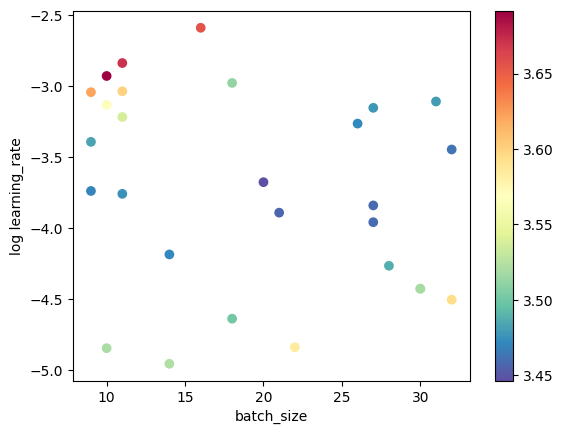

In [4]:

# create scatter plot for overview
plt.scatter(batch_size, learning_rate, c=loss, cmap='Spectral_r')
plt.xlabel('batch_size')
plt.ylabel('log learning_rate')
plt.colorbar()
plt.show()

In [5]:

# create a 2D array with the data, sorted by batch_size and learning_rate
sorted_batch_size = batch_size.unique()
sorted_batch_size.sort()
sorted_learning_rate = learning_rate.unique()
sorted_learning_rate.sort()
data = np.zeros((len(sorted_batch_size), len(sorted_learning_rate)))
lora_rank = np.zeros((len(sorted_batch_size), len(sorted_learning_rate)))
for i, bs in enumerate(sorted_batch_size):
    for j, lr in enumerate(sorted_learning_rate):
        # find the loss value for the current batch_size and learning_rate
        # not all combinations of batch_size and learning_rate are present in the data
        # so we need to check if the combination exists
        if len(BO_df[(batch_size == bs) & (learning_rate == lr)]["loss"]) > 0:
            if len(BO_df[(batch_size == bs) & (learning_rate == lr)]["loss"]) > 1:
                print(f"Warning: multiple values found for batch_size = {bs} and learning_rate = {lr}")
            data[i, j] = BO_df[(batch_size == bs) & (learning_rate == lr)]["loss"].to_numpy()[0]
            lora_rank[i, j] = BO_df[(batch_size == bs) & (learning_rate == lr)]["lora_rank"].to_numpy()[0]
        else:
            data[i, j] = np.nan




In [6]:
Z = data
x = sorted_batch_size
y = sorted_learning_rate

In [7]:
total_elements = Z.shape[0] * Z.shape[1]
nans = np.isnan(Z).sum()
percentage = nans / total_elements * 100
print(f"Percentage of missing values: {percentage:.2f}%")

Percentage of missing values: 93.33%


In [8]:
# check, if all 28 values are present
(~np.isnan(Z)).sum()

28

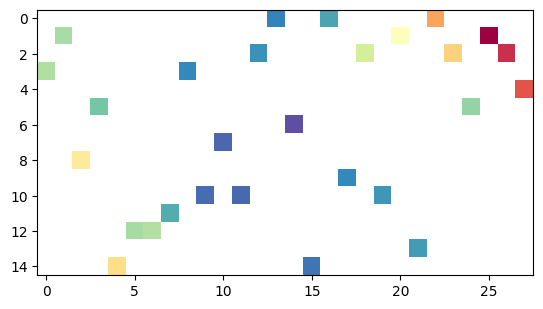

In [9]:
plt.imshow(Z, cmap='Spectral_r', interpolation='nearest')
plt.show()

Original data shape: (15, 28)
Interpolated data shape: (15, 28)


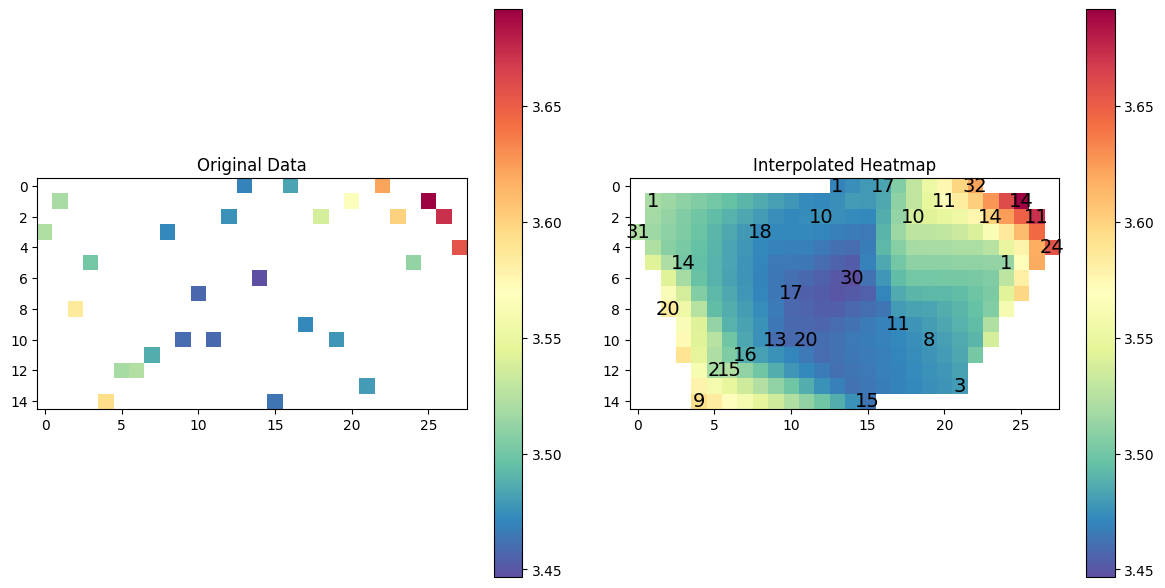

In [10]:
# # Assuming your data is stored in a variable called 'data'
# # If not, replace this with your actual data loading code
# np.random.seed(0)
# data = np.random.rand(15, 28)
# mask = np.random.choice([1, 0], data.shape, p=[0.9286, 0.0714])
# data[mask == 1] = np.nan

# data = Z

print("Original data shape:", data.shape)

# Create x and y coordinates for the grid
y, x = np.mgrid[0:data.shape[0], 0:data.shape[1]]

# Create mask of valid (not NaN) values
valid_mask = ~np.isnan(data)

# Get coordinates of valid values
x_valid = x[valid_mask]
y_valid = y[valid_mask]

# Get valid values
z_valid = data[valid_mask]

# Interpolate
f = interpolate.LinearNDInterpolator((y_valid, x_valid), z_valid)

# Create grid for interpolation
xx, yy = np.meshgrid(np.arange(data.shape[1]), np.arange(data.shape[0]))

# Interpolate the missing values
data_interpolated = f((yy, xx))

print("Interpolated data shape:", data_interpolated.shape)

# Plot the heatmap
plt.figure(figsize=(12, 6))

# Original data
plt.subplot(121)
plt.imshow(data, cmap='Spectral_r', interpolation='nearest')
plt.colorbar()
plt.title('Original Data')

# Interpolated data
plt.subplot(122)
plt.imshow(data_interpolated, cmap='Spectral_r', interpolation='nearest')
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if lora_rank[i, j] > 0:
            plt.text(j, i, f'{lora_rank[i, j]:.0f}', ha='center', va='center', color='black', fontsize=14)
plt.colorbar()
plt.title('Interpolated Heatmap')

plt.tight_layout()
plt.show()


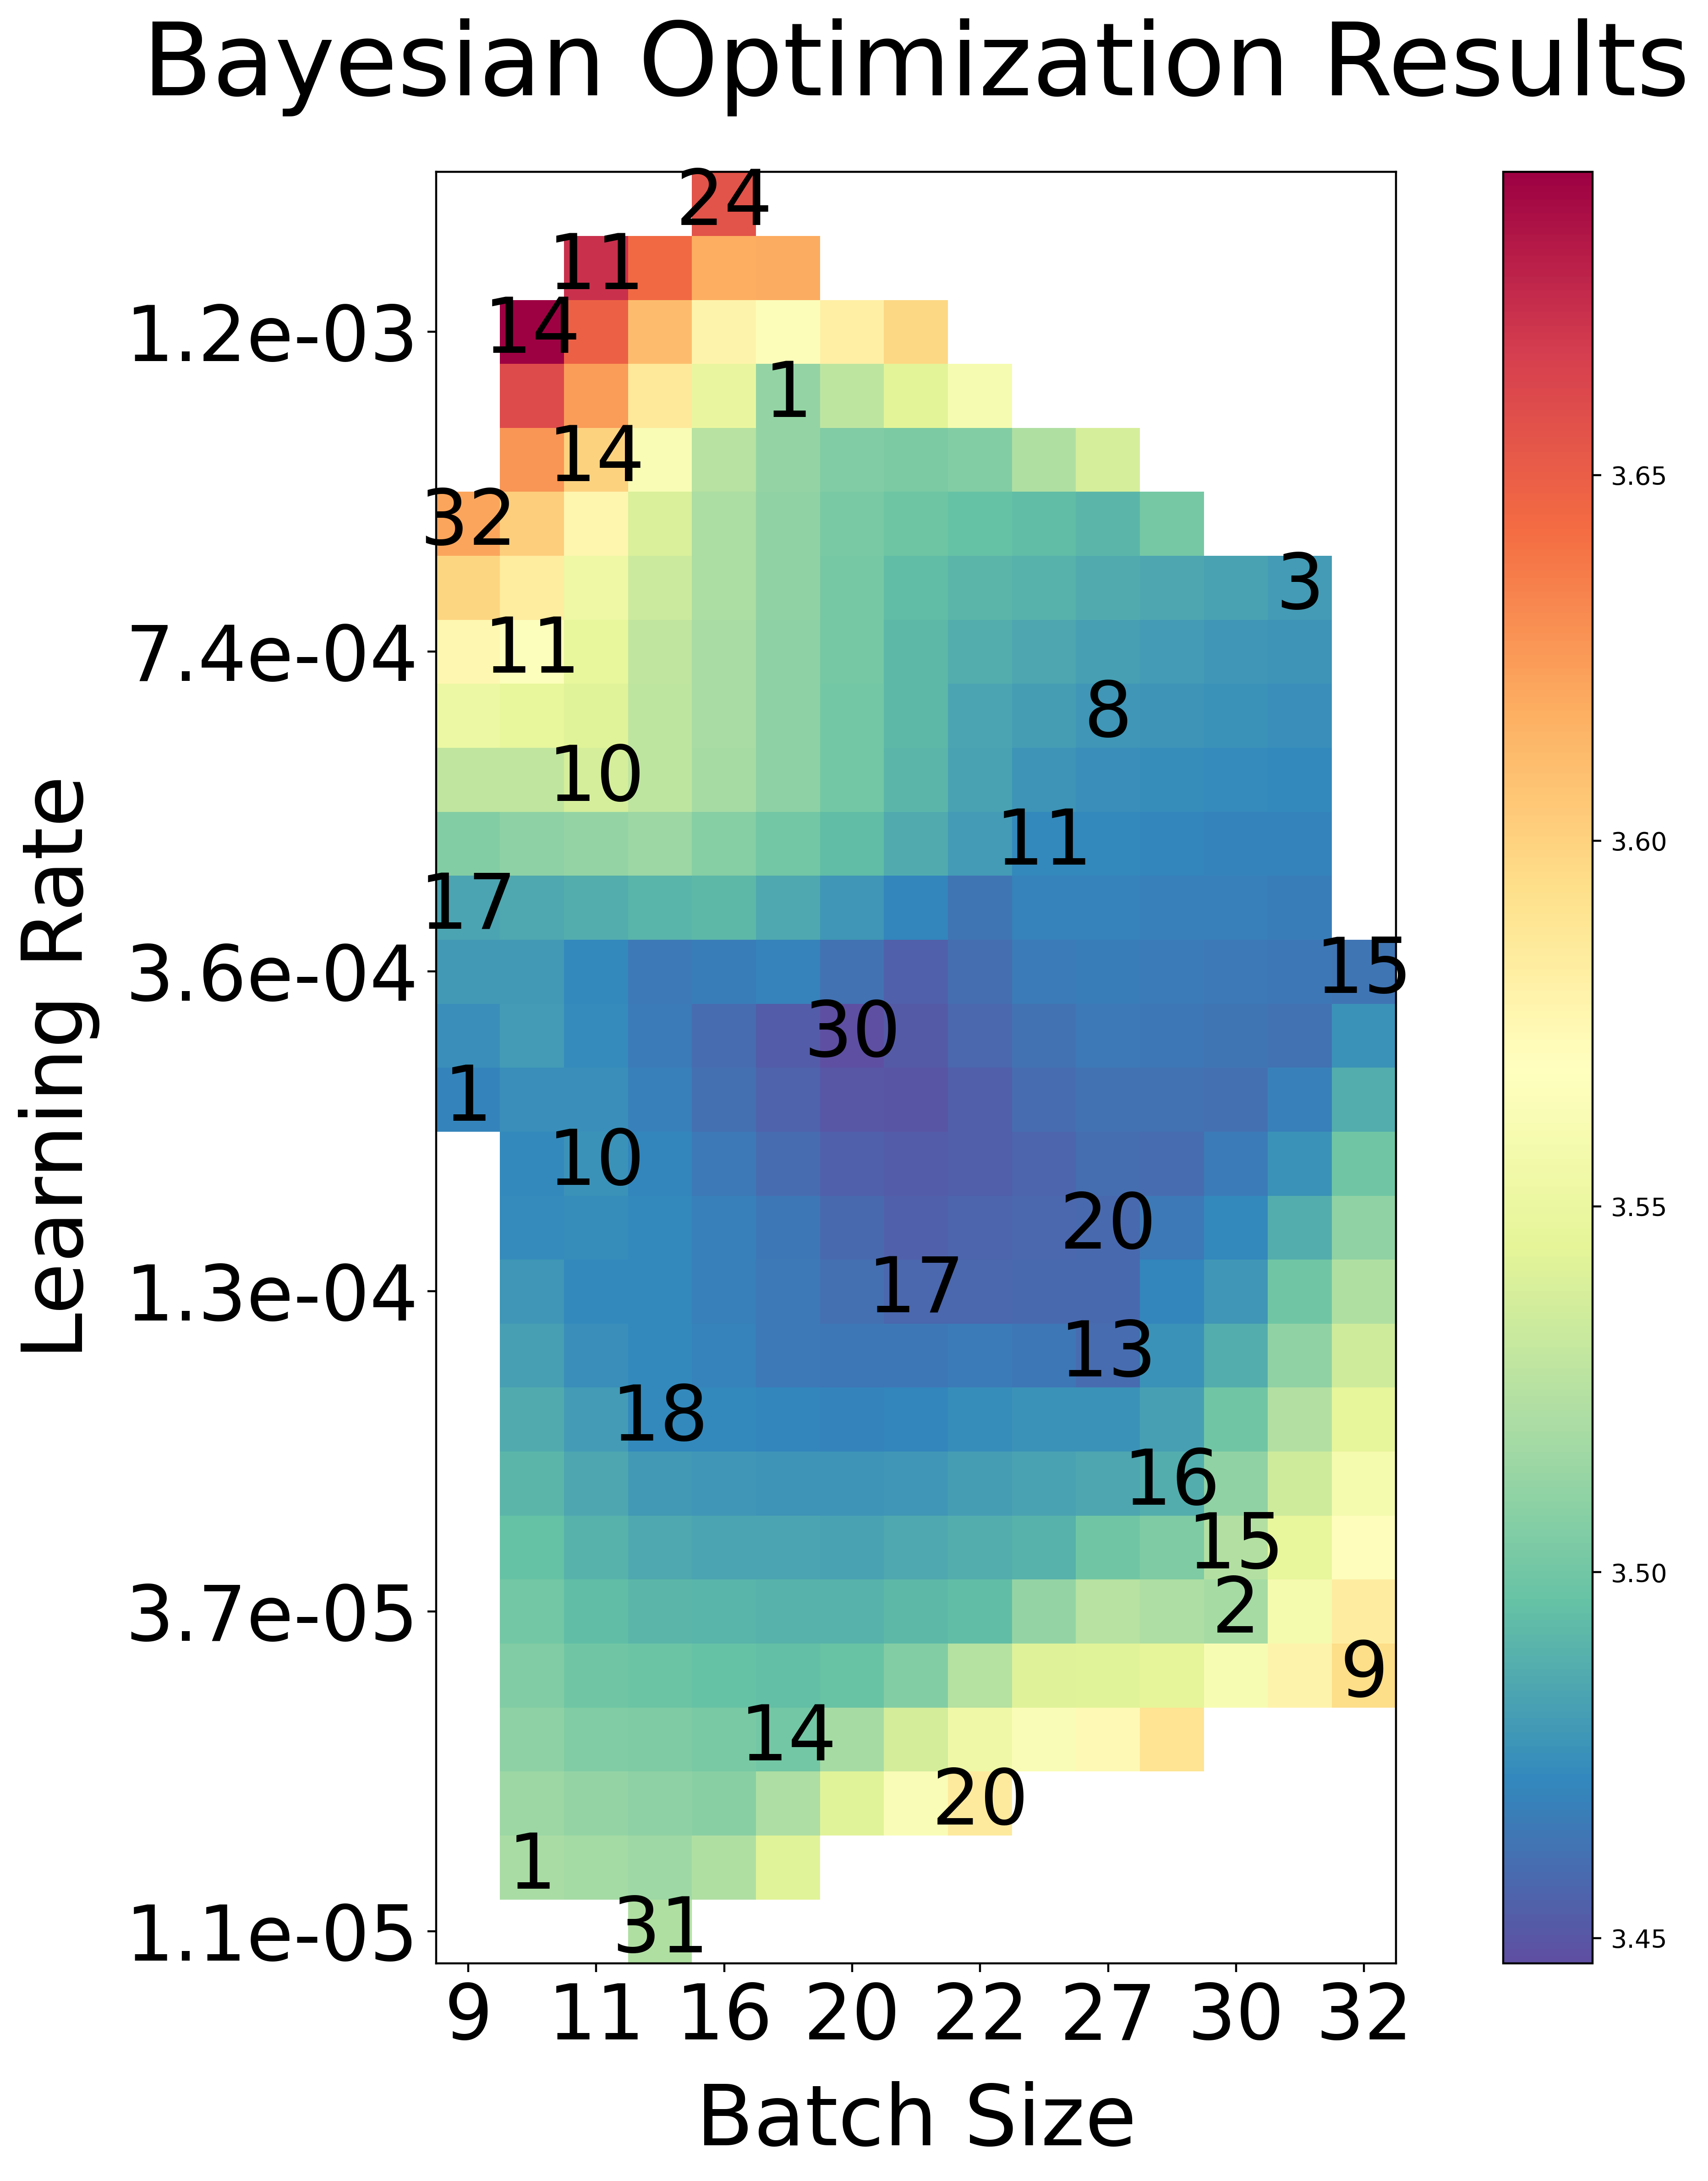

In [11]:
# plot again, with axes flipped to match the other heatmap
plt.figure(figsize=(12, 12), dpi=400)
plt.imshow(data_interpolated.T, cmap='Spectral_r', interpolation='nearest', label='loss')
for i in range(data.shape[1]):
    for j in range(data.shape[0]):
        if lora_rank.T[i, j] > 0:
            plt.text(j, i, f'{lora_rank.T[i, j]:.0f}', ha='center', va='center', color='black', fontsize=30)
# only 5 ticks on y-axis, 
plt.yticks(np.arange(0, len(sorted_learning_rate), 5), [f'{10**lr:.1e}' for lr in sorted_learning_rate[::5]], fontsize=30)
# fewer x-ticks
plt.xticks(np.arange(0, len(sorted_batch_size), 2), sorted_batch_size[::2], fontsize=30)
plt.colorbar()
plt.gca().invert_yaxis()
plt.ylabel('Learning Rate', fontsize=33, labelpad=10)
plt.xlabel('Batch Size', fontsize=33, labelpad=10)
plt.title('Bayesian Optimization Results', fontsize=40, pad=30)
plt.tight_layout()
plt.show()

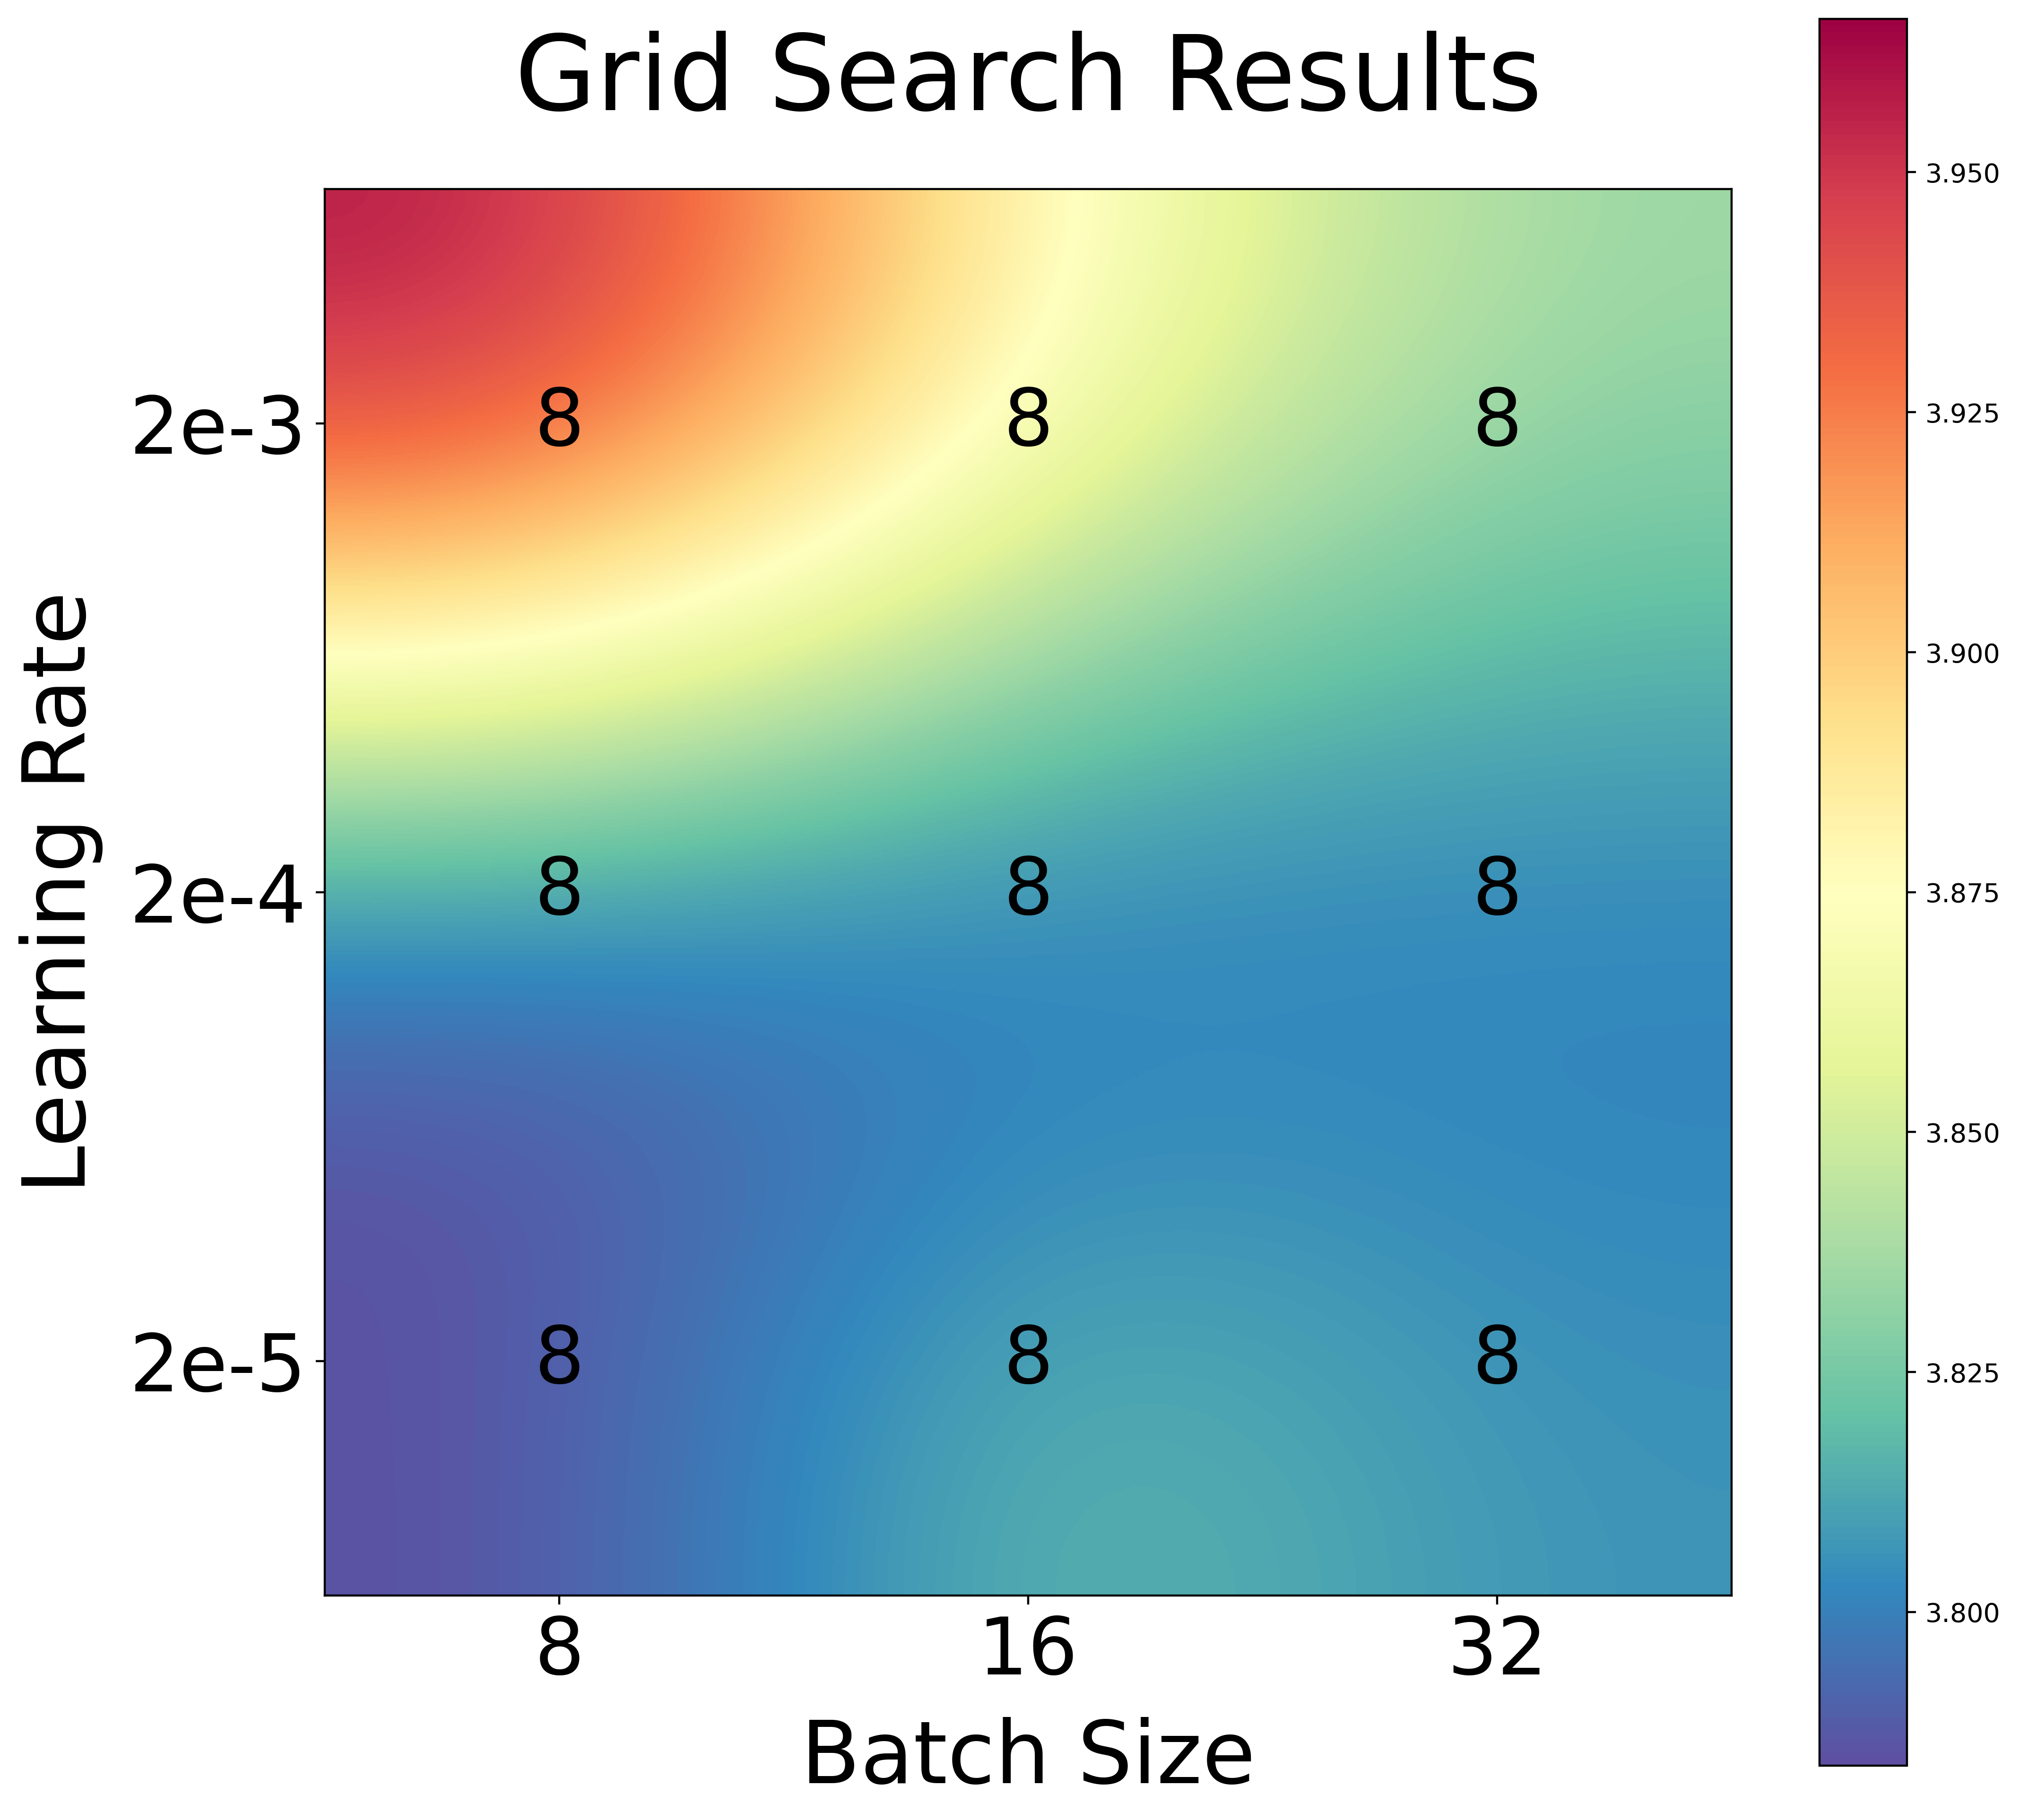

In [12]:
# grid search heatmap

data = [
    [3.966, 3.878, 3.835],
    [3.787, 3.786, 3.797],
    [3.784, 3.823, 3.806]
]

data = np.array(data)

x_labels = ['8', '16', '32']
y_labels = ['2e-3', '2e-4', '2e-5']
plt.figure(figsize=(12, 12), dpi=400)
plt.imshow(data, cmap='Spectral_r', interpolation='bicubic')
#plt.imshow(data, cmap='RdYlBu_r', interpolation='bicubic')

plt.colorbar()

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        plt.text(j, i, f'{8}', ha='center', va='center', color='black', fontsize=30)

plt.title("Grid Search Results", fontsize=40, pad=30)
plt.xlabel("Batch Size", fontsize=33, labelpad=10)
plt.ylabel("Learning Rate", fontsize=33, labelpad=10)

plt.xticks(np.arange(len(x_labels)), x_labels, fontsize=30)
plt.yticks(np.arange(len(y_labels)), y_labels, fontsize=30)

plt.show()
# plt.savefig('heat_map.png')
